In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import glob
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
train_image_path =  glob.glob('./dataset/dc_2000/train/*/*.jpg')
test_image_path =  glob.glob('./dataset/dc_2000/test/*/*.jpg')

In [4]:
train_image_path[-5:]

['./dataset/dc_2000/train/dog/dog.977.jpg',
 './dataset/dc_2000/train/dog/dog.744.jpg',
 './dataset/dc_2000/train/dog/dog.750.jpg',
 './dataset/dc_2000/train/dog/dog.988.jpg',
 './dataset/dc_2000/train/dog/dog.778.jpg']

In [5]:
train_image_label =  [int(p.split('/')[4]=='cat') for p in train_image_path]
test_image_label =  [int(p.split('/')[4]=='cat') for p in test_image_path]

In [6]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [7]:
def load_preprosese_image(path,label):
    image = tf.io.read_file(path)
    img = tf.image.decode_jpeg(image,channels=3)
    img = tf.image.resize(img,[256,256])
    img = tf.cast(img,tf.float32)
    img = img/255
    label  = tf.reshape(label,[1])
    return img,label
    

In [8]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path,test_image_label))

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
train_image_ds = train_image_ds.map(load_preprosese_image,num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.map(load_preprosese_image,num_parallel_calls=AUTOTUNE)


In [11]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [12]:
BATCH_SIZE  = 16
train_count  = len(train_image_path)//BATCH_SIZE
test_count = len(test_image_path ) //BATCH_SIZE

In [13]:
train_image_ds = train_image_ds.batch(BATCH_SIZE).shuffle(train_count)
test_image_ds = test_image_ds.batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)


In [14]:
train_image_ds

<ShuffleDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.int32)>

In [15]:
imgs,labels = next(iter(train_image_ds))

In [16]:
imgs.shape

TensorShape([16, 256, 256, 3])

In [17]:
labels.shape

TensorShape([16, 1])

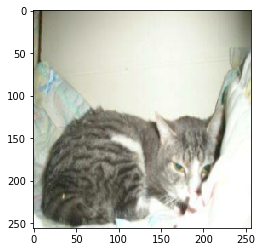

In [18]:
plt.imshow(imgs[0])

In [19]:
labels[0]

<tf.Tensor: id=73, shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [20]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),input_shape = (256,256,3),
                       activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024,(3,3),activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       1

In [22]:
imgs ,labels = next(iter(train_image_ds))

In [23]:
pred=model(imgs)

In [24]:
ls = tf.keras.losses.BinaryCrossentropy()

In [25]:
ls([0.,0.,1.,1.],[1.,1.,1.,1.])

<tf.Tensor: id=382, shape=(), dtype=float32, numpy=7.6666193>

In [26]:
tf.keras.losses.binary_crossentropy([0.,0.,1.,1.],[1.,1.,1.,1.])

<tf.Tensor: id=406, shape=(), dtype=float32, numpy=7.6666193>

In [27]:
optimizer = tf.keras.optimizers.Adam()

In [28]:
train_loss = tf.keras.metrics.Mean('train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy('train_acc')

In [29]:
test_loss = tf.keras.metrics.Mean('test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy('test_acc')

In [30]:
def train_step(model,images,labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=False)(labels,pred)
    grads = t.gradient(loss_step,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    train_loss(loss_step)
    train_acc(labels,tf.cast(pred>0,tf.int32))

In [31]:
def test_step(model,images,labels):
    pred = model(images,training=False)
    loss_step  = tf.keras.losses.BinaryCrossentropy(from_logits=False)(labels,pred)
    test_loss(loss_step)
    test_acc(labels,tf.cast(pred>0,tf.int32))

In [32]:
#定义两个空的列表放历史的loss和acc
train_loss_results = []
train_acc_results = []
test_loss_results = []
test_acc_results = []

In [33]:
num_epochs = 10

In [34]:
def train():
    for epoch in range(num_epochs):
        for imgs_,labels_ in train_image_ds:
            train_step(model,imgs_,labels)
            print('.',end='')
        print()
        train_loss_results.append(train_loss.result())
        train_acc_results.append(train_acc.result())
        
        for imgs_,labels_ in test_image_ds:
            test_step(model,imgs,labels)
        test_loss_results.append(test_loss.result())
        test_acc_results.append(test_acc.result())    
        
        print('Epoch:%d , loss = %f , acc = %f , valid_loss = %f , valid_acc = %f' %(epoch+1,train_loss.result(),train_acc.result(),test_loss.result(),test_acc.result()))
        train_loss.reset_states()
        test_loss.reset_states()
        
        train_acc.reset_states()
        test_acc.reset_states()

In [ ]:
train()

.............................................................................................................................
Epoch:1 , loss = 0.000140 , acc = 1.000000 , valid_loss = 0.000000 , valid_acc = 1.000000
......

In [ ]:
for imgs_,labels_ in train_image_ds:
            print(imgs_.shape,labels_.shape)

In [ ]:
pred